In [181]:
import numpy as np
import pandas as pd
import scipy.stats

from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import talib
from numpy import mean, absolute
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

In [182]:
# Get the data

p1 = 252

ticker1 = "PETR4.SA" 
df1 = yf.download(ticker1, "2012-01-01", "2022-12-31")
df1["Retornos"] = df1["Adj Close"].pct_change(1)
df1["Adj Low"] = df1["Low"] - (df1["Close"]-df1["Adj Close"])
df1["Adj High"] = df1["High"] - (df1["Close"]-df1["Adj Close"])
df1["Adj Open"] = df1["Open"] - (df1["Close"]-df1["Adj Close"])
df1.dropna(axis = 0, inplace = True) 
df1.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Retornos,Adj Low,Adj High,Adj Open
Date,,,,,,,,,,
2012-01-03,21.830000,22.410000,21.809999,22.410000,8.947166,22940500,0.039777,8.347166,8.947166,8.367167
2012-01-04,22.180000,22.580000,21.980000,22.570000,9.011045,18736900,0.007139,8.421044,9.021045,8.621045
2012-01-05,22.389999,22.610001,22.150000,22.309999,8.907242,19489000,-0.011519,8.747242,9.207243,8.987242
2012-01-06,22.469999,22.580000,22.250000,22.330000,8.915225,13941000,0.000896,8.835225,9.165225,9.055224
2012-01-09,22.440001,22.629999,22.280001,22.629999,9.034999,14665100,0.013435,8.685000,9.034999,8.845000


In [183]:
# Construção do alvo

# Alvo 1 - Retornos
df1["Alvo1"] = df1["Retornos"].shift(-1)

# Criação do alvo categórico
df1["Alvo1_cat"] = np.where(df1["Alvo1"] > 0 , 1, 0)

In [184]:
# Insigths práticos

df1["doji_star"] = talib.CDLDOJISTAR(df1["Adj Open"], df1["Adj High"], df1["Adj Low"], df1["Adj Close"])
df1["doji_star"] = np.where(df1["doji_star"] == 100, 1
                            , np.where(df1["doji_star"] == -100, -1, 0))

In [185]:
df1["marubozu"] = talib.CDLCLOSINGMARUBOZU(df1["Adj Open"], df1["Adj High"], df1["Adj Low"], df1["Adj Close"])
df1["marubozu"] = np.where(df1["marubozu"] == 100, 1
                            , np.where(df1["marubozu"] == -100, -1, 0))

In [186]:
df1["harami"] = talib.CDLHARAMI(df1["Adj Open"], df1["Adj High"], df1["Adj Low"], df1["Adj Close"])
df1["harami"] = np.where(df1["harami"] == 100, 1
                            , np.where(df1["harami"] == -100, -1, 0))

In [187]:
df1["engolfo"] = talib.CDLENGULFING(df1["Adj Open"], df1["Adj High"], df1["Adj Low"], df1["Adj Close"])
df1["engolfo"] = np.where(df1["engolfo"] == 100, 1
                            , np.where(df1["engolfo"] == -100, -1, 0))

In [188]:
df1["martelo"] = talib.CDLHAMMER(df1["Adj Open"], df1["Adj High"], df1["Adj Low"], df1["Adj Close"])
df1["martelo"] = np.where(df1["martelo"] == 100, 1
                            , np.where(df1["martelo"] == -100, -1, 0))

In [189]:
# Concatenação dos nossos 5 dataframes para modelagem
# Ou seja, é um modelo que seria aplicado quando e apenas se algum do padrões fosse identificado

df_doji = df1[df1["doji_star"] != 0]
df_doji.dropna(inplace = True)

df_harami = df1[df1["harami"] != 0]
df_harami.dropna(inplace = True)

df_marubozu = df1[df1["marubozu"] != 0]
df_marubozu.dropna(inplace = True)

df_engolfo = df1[df1["engolfo"] != 0]
df_engolfo.dropna(inplace = True)

df_martelo = df1[df1["martelo"] != 0]
df_martelo.dropna(inplace = True)

df_padroes = pd.concat([df_doji, df_harami, df_marubozu, df_engolfo, df_martelo]) # se for remover ou adicionar, faça aqui
df_padroes.dropna(inplace = True)

alvo = "Alvo1_cat"

df_padroes = df_padroes[[alvo, "Alvo1", "doji_star", "harami", "marubozu", "engolfo", "martelo"]] # E aqui

df_padroes.head(10)

,Alvo1_cat,Alvo1,doji_star,harami,marubozu,engolfo,martelo
Date,,,,,,,
2012-02-17,0,-0.005405,-1,0,0,0,0
2012-07-13,0,0.000000,-1,0,0,0,0
2013-04-12,0,-0.040646,1,0,0,0,0
2013-06-20,0,-0.028419,1,0,0,0,0
2013-06-24,1,0.011942,1,0,0,0,0
2013-07-23,0,-0.001219,-1,0,0,0,0
2013-09-06,1,0.023086,-1,0,0,0,0
2013-09-16,1,0.004336,-1,0,0,0,0
2014-04-09,0,-0.010726,1,0,0,0,0


In [190]:
# Separando os dados com as variaveis em x e o alvo em y

# Separando os dados entre treinamento e teste

# Vamos treinar
start_train = "2012-01-01"
end_train = "2017-12-31"

# Vamos testar
start_test = "2018-01-01"
end_test = "2022-12-31"

df1_train = df_padroes.loc[start_train : end_train]

df1_test = df_padroes.loc[start_test : end_test]


# Separando os dados com as variaveis em x e o alvo em y
 
x_train = df1_train.drop([alvo, "Alvo1"], axis = 1)
y_train = df1_train[alvo]

x_test = df1_test.drop([alvo, "Alvo1"], axis = 1)
y_test = df1_test[alvo]

In [191]:
print(x_train.shape)
print(x_test.shape)

(623, 5)
(496, 5)


In [192]:
# Treinando o modelo
#10,10,10
model = MLPClassifier(hidden_layer_sizes = (10,10,10,10,100), max_iter = 50,
                    solver = "sgd", verbose = 10, tol = 1e-4, random_state = 42,
                    learning_rate_init = .001, activation = "tanh")

model.fit(x_train, y_train) # essa é a linha que treina o modelo!!!!

Iteration 1, loss = 0.72886819
Iteration 2, loss = 0.72526416
Iteration 3, loss = 0.71923423
Iteration 4, loss = 0.71367176
Iteration 5, loss = 0.70821086
Iteration 6, loss = 0.70361796
Iteration 7, loss = 0.69988243
Iteration 8, loss = 0.69670079
Iteration 9, loss = 0.69475131
Iteration 10, loss = 0.69339704
Iteration 11, loss = 0.69243195
Iteration 12, loss = 0.69188853
Iteration 13, loss = 0.69143557
Iteration 14, loss = 0.69098665
Iteration 15, loss = 0.69046657
Iteration 16, loss = 0.69029128
Iteration 17, loss = 0.69005033
Iteration 18, loss = 0.68989255
Iteration 19, loss = 0.68982100
Iteration 20, loss = 0.68973814
Iteration 21, loss = 0.68962356
Iteration 22, loss = 0.68950068
Iteration 23, loss = 0.68943257
Iteration 24, loss = 0.68940482
Iteration 25, loss = 0.68941196
Iteration 26, loss = 0.68938899
Iteration 27, loss = 0.68939874
Iteration 28, loss = 0.68937306
Iteration 29, loss = 0.68939041
Iteration 30, loss = 0.68937861
Iteration 31, loss = 0.68934440
Iteration 32, los

MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 10, 10, 10, 100),
              max_iter=50, random_state=42, solver='sgd', verbose=10)

In [193]:
model.score(x_test, y_test)

0.5504032258064516

In [194]:
# Calculando a performance - para toda a base
custo_op = 0.0001 
#0.1% - R$2 reais em R$20000, assumindo operação completa - C/V
#Cada ponto de um mini contrato de índice: R$0.20 - Assumindo então o indice em média de 100k pontos

y_pred_all = model.predict(df_padroes.drop([alvo, "Alvo1"], axis = 1))
df_padroes.loc[: , "Previsto"] = y_pred_all
df_padroes.loc[: , "Previsto"] = np.where(df_padroes.loc[: , "Previsto"] == 1, 1, -1)
df_padroes.loc[:, "Sinal"] = np.sign(df_padroes.loc[: , "Previsto"])
df_padroes.loc[: , "Retorno_Modelo"] = df_padroes.loc[:, "Sinal"]*df_padroes["Alvo1"] - custo_op

In [195]:
# Para fazer um conditional plot

df_padroes.index.name = "Data"
df_padroes.reset_index(inplace = True)

df_padroes["Data"] = pd.to_datetime(df_padroes["Data"])

df_padroes["train_test"] = np.where(df_padroes["Data"] > end_train, 1, -1)

base_agregada = df_padroes.resample("M", on = "Data").sum()

base_agregada.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada["Retorno_Modelo"].cumsum()*100

""


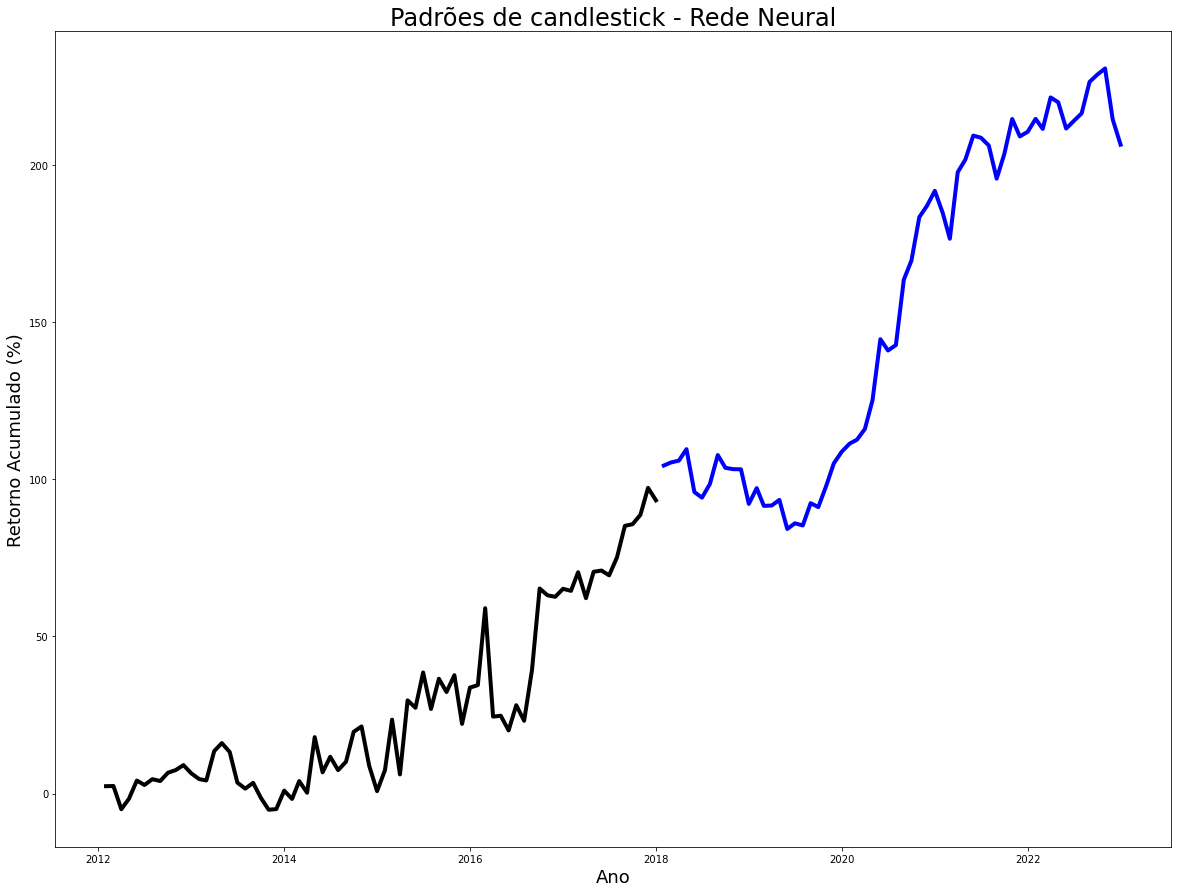

In [196]:
# Plota o gráfico
fig, ax = plt.subplots(figsize = (20, 15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c = color, linewidth = lw)
    plt.xlabel("Ano"
           , fontsize = 18);
    plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 18);
    plt.title("Padrões de candlestick - Rede Neural", fontsize = 24)
    #plt.axvline( x = end_train, color='purple', linestyle = "--", lw = 2)

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)



In [197]:
summary = df_padroes.copy()
summary["Data"] = pd.to_datetime(summary["Data"], format = "%Y-%m")

summary = summary.groupby([summary["Data"].dt.year]).agg({"Retorno_Modelo": sum})

summary.index = summary.index.set_names(["Ano"])

summary*100

,Retorno_Modelo
Ano,
2012,6.435531
2013,-5.490518
2014,-0.165023
2015,32.955477
2016,31.439007
2017,28.164208
2018,-1.154545
2019,16.605065
2020,83.033814


In [198]:
base_agregada.tail()

,Alvo1_cat,Alvo1,doji_star,harami,marubozu,engolfo,martelo,Previsto,Sinal,Retorno_Modelo,train_test,Retorno_Modelo_Acumulado
Data,,,,,,,,,,,,
2022-08-31,5,0.109993,0,-1,0,0,0,1,1,0.099955,5,226.504767
2022-09-30,2,0.011530,0,0,0,0,1,1,1,0.022742,3,228.778997
2022-10-31,1,-0.002225,0,-1,-1,-2,0,2,2,0.019974,4,230.776423
2022-11-30,4,-0.077471,0,2,-1,-3,0,6,6,-0.162015,8,214.574910
2022-12-31,2,-0.080063,0,1,-2,-2,0,5,5,-0.080563,5,206.518601
